# NLP

In [1]:
# Basic setup
import os, re, sys, math, random, json, string, collections, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)
random.seed(42)

# Pretty printing for pandas
pd.set_option("display.max_colwidth", 120)

## 1) Download & Load the IMDB dataset

In [2]:
%%bash
set -e
if [ ! -d "aclImdb" ]; then
  wget -q http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -O aclImdb_v1.tar.gz
  tar zxf aclImdb_v1.tar.gz
  rm -rf aclImdb/train/unsup
fi
ls -lah aclImdb | sed -n '1,10p'
echo ""
head -n 20 aclImdb/README

total 1.7M
drwxr-xr-x 4 7297 1000 4.0K Jun 26  2011 .
drwxr-xr-x 1 root root 4.0K Aug 31 11:16 ..
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Aug 31 11:16 test
drwxr-xr-x 4 7297 1000 4.0K Aug 31 11:16 train

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for 

In [3]:
# Load using sklearn.datasets.load_files
from sklearn.datasets import load_files

train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target

test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target

print("Label names:", train_review.target_names)
print("Train size:", len(x_train), " Test size:", len(x_test))
print("Sample review snippet:", x_train[0][:400])

Label names: ['neg', 'pos']
Train size: 25000  Test size: 25000
Sample review snippet: Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time t


## 2) BoW (CountVectorizer) - Mini example

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

mini_dataset = [
  "This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."
]

vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = vectorizer.fit_transform(mini_dataset).toarray()
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names_out())
df

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


### 2-gram (bigram) example

In [5]:
vectorizer2 = CountVectorizer(ngram_range=(2,2), token_pattern=r'(?u)\b\w+\b')
bow2 = vectorizer2.fit_transform(mini_dataset).toarray()
df2 = pd.DataFrame(bow2, columns=vectorizer2.get_feature_names_out())
df2

,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


## 3) Problem 1 - Scratch BoW (1-gram & 2-gram) on the three sentences

In [6]:
toy = [
    "This movie is SOOOO funny!!!",
    "What a movie! I never",
    "best movie ever!!!!! this movie",
]

def simple_tokenize(s):
    s = s.lower()
    s = re.sub(r"https?://\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s.split()

def ngrams(tokens, n):
    return [" ".join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def bow_scratch(sentences, n_range=(1,1)):
    # Build vocab
    vocab = collections.Counter()
    docs = []
    for s in sentences:
        toks = simple_tokenize(s)
        grams = []
        for n in range(n_range[0], n_range[1]+1):
            grams += (toks if n==1 else ngrams(toks, n))
        docs.append(grams)
        vocab.update(grams)
    vocab_list = sorted(vocab.keys())
    idx = {t:i for i,t in enumerate(vocab_list)}
    X = np.zeros((len(docs), len(vocab_list)), dtype=int)
    for r, grams in enumerate(docs):
        for g in grams:
            X[r, idx[g]] += 1
    return X, vocab_list

for n_range in [(1,1),(2,2)]:
    Xb, vocab = bow_scratch(toy, n_range=n_range)
    display(pd.DataFrame(Xb, columns=vocab))

,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,0,0,0,1,0,1,1,0,1,1,0
1,1,0,0,0,1,0,1,1,0,0,1
2,0,1,1,0,0,0,2,0,0,1,0


,a movie,best movie,ever this,i never,is soooo,movie ever,movie i,movie is,soooo funny,this movie,what a
0,0,0,0,0,1,0,0,1,1,1,0
1,1,0,0,1,0,0,1,0,0,0,1
2,0,1,1,0,0,1,0,0,0,1,0


## 4) Problem 2

In [7]:
# NLTK stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
len(stop_words), stop_words[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(198,
 ['a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an'])

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer default uses sklearn's idf smoothing and l2 normalization.
# We'll keep norm=None first for a raw view, then an L2-normalized variant.
tfidf_raw = TfidfVectorizer(stop_words=stop_words, max_features=5000, token_pattern=r'(?u)\b\w+\b', norm=None)
Xtr_tfidf = tfidf_raw.fit_transform(x_train)
Xte_tfidf = tfidf_raw.transform(x_test)

print("Train TF-IDF shape:", Xtr_tfidf.shape, " Test TF-IDF shape:", Xte_tfidf.shape)
print("Example features:", tfidf_raw.get_feature_names_out()[:20])

Train TF-IDF shape: (25000, 5000)  Test TF-IDF shape: (25000, 5000)
Example features: ['0' '00' '000' '1' '10' '100' '11' '12' '13' '13th' '14' '15' '16' '17'
 '18' '1930' '1930s' '1933' '1940' '1950']


## 5) Problem 3 - Train a classifier on TF–IDF vectors

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = LogisticRegression(max_iter=200, n_jobs=None)  # liblinear/ saga could also work
clf.fit(Xtr_tfidf, y_train)
pred = clf.predict(Xte_tfidf)
acc = accuracy_score(y_test, pred)
print("LogReg (TF-IDF ~5k vocab) — Test accuracy:", f"{acc:.4f}")
print("\nReport:\n", classification_report(y_test, pred, target_names=train_review.target_names))

LogReg (TF-IDF ~5k vocab) — Test accuracy: 0.8157

Report:
               precision    recall  f1-score   support

         neg       0.81      0.83      0.82     12500
         pos       0.82      0.80      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



### Experiments: change max_features, n-gram, normalization

In [10]:
def tfidf_experiment(max_features=5000, ngram_range=(1,1), norm='l2'):
    vec = TfidfVectorizer(stop_words=stop_words, max_features=max_features, ngram_range=ngram_range,
                          token_pattern=r'(?u)\b\w+\b', norm=norm)
    Xtr = vec.fit_transform(x_train); Xte = vec.transform(x_test)
    model = LogisticRegression(max_iter=200)
    model.fit(Xtr, y_train)
    pred = model.predict(Xte)
    return accuracy_score(y_test, pred)

for mf in [3000, 5000, 10000]:
    print("max_features=", mf, " acc=", tfidf_experiment(max_features=mf))

print("bigram acc:", tfidf_experiment(max_features=8000, ngram_range=(1,2)))
print("no normalization acc:", tfidf_experiment(max_features=5000, norm=None))

max_features= 3000  acc= 0.882
max_features= 5000  acc= 0.88344
max_features= 10000  acc= 0.88548
bigram acc: 0.89072
no normalization acc: 0.81568


## 6) Problem 4

In [11]:
def tf_idf_standard(sentences, ngram_range=(1,1)):
    # Build corpus BoW document-wise (counts)
    docs_tokens = []
    vocab = set()
    for s in sentences:
        toks = simple_tokenize(s)
        grams = []
        for n in range(ngram_range[0], ngram_range[1]+1):
            grams += (toks if n==1 else ngrams(toks, n))
        docs_tokens.append(grams)
        vocab.update(grams)
    vocab = sorted(vocab)
    idx = {t:i for i,t in enumerate(vocab)}
    N = len(sentences)
    # counts and df
    X_counts = np.zeros((N, len(vocab)), dtype=float)
    df = np.zeros(len(vocab), dtype=int)
    for i, grams in enumerate(docs_tokens):
        seen = set()
        for g in grams:
            j = idx[g]; X_counts[i,j] += 1.0
            if g not in seen:
                df[j] += 1; seen.add(g)
    # Standard TF: count / total tokens in doc
    tf = X_counts / np.maximum(X_counts.sum(axis=1, keepdims=True), 1)
    # Standard IDF: log(N / df)
    idf = np.log(N / np.maximum(df, 1))
    # TF-IDF
    tfidf = tf * idf
    return pd.DataFrame(tfidf, columns=vocab), pd.Series(df, index=vocab), pd.Series(idf, index=vocab)

def tf_idf_sklearn_style(sentences, ngram_range=(1,1)):
    # Same tokenization as above
    docs_tokens = []
    vocab = set()
    for s in sentences:
        toks = simple_tokenize(s)
        grams = []
        for n in range(ngram_range[0], ngram_range[1]+1):
            grams += (toks if n==1 else ngrams(toks, n))
        docs_tokens.append(grams); vocab.update(grams)
    vocab = sorted(vocab); idx = {t:i for i,t in enumerate(vocab)}
    N = len(sentences)
    # counts and df
    X_counts = np.zeros((N, len(vocab)), dtype=float)
    df = np.zeros(len(vocab), dtype=int)
    for i, grams in enumerate(docs_tokens):
        seen = set()
        for g in grams:
            j = idx[g]; X_counts[i,j] += 1.0
            if g not in seen:
                df[j] += 1; seen.add(g)
    # sklearn TF: raw counts
    tf = X_counts
    # sklearn IDF: log( (1+N) / (1+df) ) + 1
    idf = np.log((1+N) / (1+df)) + 1.0
    tfidf = tf * idf
    return pd.DataFrame(tfidf, columns=vocab), pd.Series(df, index=vocab), pd.Series(idf, index=vocab)

toy_df_std, toy_df_df_std, toy_idf_std = tf_idf_standard(toy, ngram_range=(1,1))
toy_df_skl, toy_df_df_skl, toy_idf_skl = tf_idf_sklearn_style(toy, ngram_range=(1,1))

print("Standard TF-IDF:")
display(toy_df_std.round(3))
print("sklearn-style TF-IDF:")
display(toy_df_skl.round(3))

Standard TF-IDF:


,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,0.00,0.00,0.00,0.22,0.00,0.22,0.0,0.00,0.22,0.081,0.00
1,0.22,0.00,0.00,0.00,0.22,0.00,0.0,0.22,0.00,0.000,0.22
2,0.00,0.22,0.22,0.00,0.00,0.00,0.0,0.00,0.00,0.081,0.00


sklearn-style TF-IDF:


,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,0.000,0.000,0.000,1.693,0.000,1.693,1.0,0.000,1.693,1.288,0.000
1,1.693,0.000,0.000,0.000,1.693,0.000,1.0,1.693,0.000,0.000,1.693
2,0.000,1.693,1.693,0.000,0.000,0.000,2.0,0.000,0.000,1.288,0.000


## 7) Problem 5 - Corpus preprocessing for Word2Vec

In [12]:
URL_RE = re.compile(r"https?://\S+")
PUNCT_TABLE = str.maketrans({c: " " for c in string.punctuation})

def normalize_text(s):
    s = s.lower()
    s = URL_RE.sub(" ", s)
    s = s.translate(PUNCT_TABLE)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize_text(s):
    return normalize_text(s).split()

# Build tokenized corpus from train reviews
corpus_tokens = [tokenize_text(doc) for doc in x_train]
print("Example tokens:", corpus_tokens[0][:25])

Example tokens: ['zero', 'day', 'leads', 'you', 'to', 'think', 'even', 're', 'think', 'why', 'two', 'boys', 'young', 'men', 'would', 'do', 'what', 'they', 'did', 'commit', 'mutual', 'suicide', 'via', 'slaughtering', 'their']


## 8) Problem 6 - Train Word2Vec (Gensim)

In [13]:
!pip install gensim
import gensim
from gensim.models import Word2Vec

# Gensim v4 uses 'vector_size' instead of 'size'
w2v_kwargs = dict(min_count=2, window=5, workers=4, sg=1)  # sg=1 -> Skip-gram, commonly better than CBOW
try:
    model = Word2Vec(vector_size=100, **w2v_kwargs)
except TypeError:
    # Fallback for very old versions
    model = Word2Vec(size=100, **w2v_kwargs)

model.build_vocab(corpus_tokens)
model.train(corpus_tokens, total_examples=model.corpus_count, epochs=5)

print("Vocab size:", len(model.wv))
print("Most similar to 'good':", model.wv.most_similar(positive=['good'])[:5])

Vocab size: 47054
Most similar to 'good': [('decent', 0.7972573637962341), ('great', 0.7951153516769409), ('bad', 0.7823132872581482), ('nice', 0.7589359283447266), ('passable', 0.7529649138450623)]


## 9) Problem 7 - t-SNE visualization of word vectors & nearest words

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


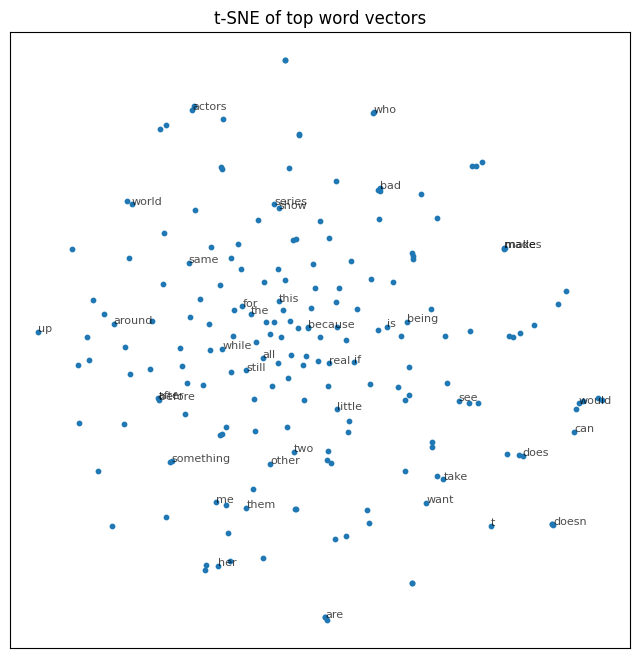

Nearest to 'good': ['decent', 'great', 'bad', 'nice', 'passable', 'awsome', 'warranted', 'fine']
Nearest to 'bad': ['terrible', 'horrible', 'awful', 'good', 'lousy', 'cheezy', 'stupid', 'sucks']
Nearest to 'film': ['movie', 'necromancy', 'picture', 'documentary', 'flick', 'brevity', 'dramedy', 'mockumentary']
Nearest to 'movie': ['film', 'flick', 'monstrosity', 'programme', 'baseketball', 'summation', 'dcom', 'it']
Nearest to 'great': ['wonderful', 'fantastic', 'terrific', 'good', 'fine', 'marvellous', 'marvelous', 'brilliant']
Nearest to 'terrible': ['horrible', 'awful', 'horrendous', 'horrid', 'dreadful', 'atrocious', 'bad', 'abysmal']


In [14]:
from sklearn.manifold import TSNE

# Choose top-N frequent words for a readable plot
topn = 200
# Get words by frequency
words_by_freq = sorted(model.wv.key_to_index, key=lambda w: model.wv.get_vecattr(w, 'count'), reverse=True)
sel_words = [w for w in words_by_freq if w.isalpha()][:topn]

vecs = np.vstack([model.wv[w] for w in sel_words])
tsne = TSNE(n_components=2, perplexity=35, learning_rate='auto', init="pca", random_state=42, n_iter=1000)
XY = tsne.fit_transform(vecs)

plt.figure(figsize=(8,8))
plt.scatter(XY[:,0], XY[:,1], s=10)
for i, w in enumerate(sel_words):
    if i % 5 == 0:  # annotate sparsely for readability
        plt.annotate(w, (XY[i,0], XY[i,1]), fontsize=8, alpha=0.7)
plt.title("t-SNE of top word vectors")
plt.xticks([]); plt.yticks([])
plt.show()

for probe in ["good","bad","film","movie","great","terrible"]:
    if probe in model.wv:
        print(f"Nearest to '{probe}':", [w for w,_ in model.wv.most_similar(probe)[:8]])

## 10) Problem 8 - IMDB classification using Word2Vec doc-averages

In [15]:
def doc_vector_avg(tokens, wv, k=100):
    # average vectors for tokens present in vocab
    vecs = [wv[w] for w in tokens if w in wv]
    if not vecs:
        return np.zeros(k, dtype=np.float32)
    return np.mean(vecs, axis=0)

Xtr_wv = np.vstack([doc_vector_avg(tokenize_text(t), model.wv, k=model.vector_size) for t in x_train])
Xte_wv = np.vstack([doc_vector_avg(tokenize_text(t), model.wv, k=model.vector_size) for t in x_test])

clf_wv = LogisticRegression(max_iter=300)
clf_wv.fit(Xtr_wv, y_train)
pred_wv = clf_wv.predict(Xte_wv)
acc_wv = accuracy_score(y_test, pred_wv)
print("LogReg (avg Word2Vec) — Test accuracy:", f"{acc_wv:.4f}")

LogReg (avg Word2Vec) — Test accuracy: 0.8523
